In [16]:
# ----------------------------------------------------------------------------
# Title: Assignment 5.2
# Author: Surenther Selvaraj
# Date: 08 Oct 2025
# Modified By: Surenther Selvaraj
# Description: Build your own Sentiment Analysis Model
# Data: https://www.kaggle.com/c/word2vec-nlp-tutorial/data
# ----------------------------------------------------------------------------

In [35]:
# --- Importing Libraries ---
import pandas as pd
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In [18]:
#Import the movie review data

# The name of the file
file_name = "labeledTrainData.tsv"

# Using pandas.read_csv with the correct delimiter for a .tsv file
df = pd.read_csv(file_name, sep='\t')

# Check if the data is loaded properly by displaying the first few rows
print("\nFirst 5 rows of the DataFrame:")
print(df.head())


First 5 rows of the DataFrame:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...


In [19]:
# --- Getting the Stemmed Data ---

# Download the NLTK stop words list
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

def clean_and_stem_review(raw_review):
    # a. Remove HTML tags using a regular expression
    review_text = re.sub('<[^<]+?>', '', raw_review)

    # b. Remove non-alphabetic characters and convert to lowercase
    letters_only = re.sub("[^a-zA-Z]", " ", review_text).lower()

    # c. Tokenize the text (split into words)
    words = letters_only.split()

    # d. Remove stop words
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]

    # e. Stem the remaining words using PorterStemmer
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(w) for w in meaningful_words]

    # f. Join the words back into a single string
    return " ".join(stemmed_words)


# --- Apply the Function to All Reviews ---
print("\nCleaning and stemming the training data...")

# Apply the function to each review in the DataFrame's 'review' column
df['stemmed_review'] = df['review'].apply(clean_and_stem_review)

print("Processing complete.")


# --- Display the Results ---
# Show the first few rows with the original and stemmed reviews for comparison.
print("\n--- Original vs. Stemmed Reviews ---")
print(df[['review', 'stemmed_review']].head())

# Save the result to a new file for future use
df.to_csv('stemmed_movie_reviews.csv', index=False)
print("\nStemmed data has been saved to 'stemmed_movie_reviews.csv'")



Cleaning and stemming the training data...
Processing complete.

--- Original vs. Stemmed Reviews ---
                                              review  \
0  With all this stuff going down at the moment w...   
1  \The Classic War of the Worlds\" by Timothy Hi...   
2  The film starts with a manager (Nicholas Bell)...   
3  It must be assumed that those who praised this...   
4  Superbly trashy and wondrously unpretentious 8...   

                                      stemmed_review  
0  stuff go moment mj start listen music watch od...  
1  classic war world timothi hine entertain film ...  
2  film start manag nichola bell give welcom inve...  
3  must assum prais film greatest film opera ever...  
4  superbl trashi wondrous unpretenti exploit hoo...  

Stemmed data has been saved to 'stemmed_movie_reviews.csv'


In [20]:
# --- Spliting Training & Test Set ---
# Load the CSV file created in the previous step.
file_name = "stemmed_movie_reviews.csv"
try:
    df = pd.read_csv(file_name)
    print(f"Successfully loaded '{file_name}'.")
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found. Please run the stemming script first.")
    exit() # Exit if the required file doesn't exist.

# --- Define Features (X) and Target (y) ---
# The features are the processed review texts.
# The target is the 'sentiment' column (1 for positive, 0 for negative).
X = df['stemmed_review']
y = df['sentiment']

# --- Split the Data ---
# We will create a 75/25 split for training and testing.
# random_state ensures the split is the same every time, making results reproducible.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# --- Verify the Split ---
# Print the number of reviews in each set to confirm the split was successful.
print("\n--- Data Split Complete ---")
print(f"Number of reviews in the training set: {len(X_train)}")
print(f"Number of reviews in the test set:     {len(X_test)}")


Successfully loaded 'stemmed_movie_reviews.csv'.

--- Data Split Complete ---
Number of reviews in the training set: 18750
Number of reviews in the test set:     6250


In [27]:
# --- Apply TF-IDF Vectorization ---

# Initialize the TfidfVectorizer
# We'll limit the vocabulary to the 5,000 most frequent words to keep the feature set manageable.
vectorizer = TfidfVectorizer(max_features=5000,stop_words='english')

#  Fit the vectorizer to the training data and transform it
# .fit_transform() learns the vocabulary and IDF from X_train and then creates the TF-IDF matrix.
X_train_tfidf = vectorizer.fit_transform(X_train)

# --- Verify the Transformation ---
# Display the shape of the resulting TF-IDF matrix.
# The shape will be (number of training reviews, number of features/words).
print("\n--- TF-IDF Vectorization Complete ---")
print(f"The shape of the training data is: {X_train_tfidf.shape}")


--- TF-IDF Vectorization Complete ---
The shape of the training data is: (18750, 5000)


In [23]:
# --- Apply TF-IDF Vectorization for test ---

# Transform the test data using the SAME fitted vectorizer
# We use .transform() ONLY, not .fit_transform().
X_test_tfidf = vectorizer.transform(X_test)


# --- 3. Verify the Transformation ---
print("\n--- TF-IDF Vectorization of Test Sets ---")
print(f"Shape of the test data:     {X_test_tfidf.shape}")


--- TF-IDF Vectorization of Test Sets ---
Shape of the test data:     (6250, 5000)


To prevent data leakage, the test set must remain entirely unseen during the model training pipeline, including all feature engineering steps.

The .fit() method learns a model's parameters. For a TfidfVectorizer, this means learning the vocabulary and calculating the IDF weights from the provided data. This learning process is considered part of the training phase.

If the vectorizer is fitted to the test set, it gains knowledge of the test data's statistical properties before the evaluation. This contaminates the test set, invalidating it as a tool for unbiased performance assessment. The resulting metrics would be overly optimistic and not reflective of real-world generalization.

Therefore, the proper methodology is to fit the vectorizer exclusively on the training data. The resulting fitted object is then used to transform both the training and the test sets, ensuring a consistent and valid feature space for both. This correctly simulates the model's application to new, unknown data.

In [ ]:
# --- Train the Logistic Regression Model ---
print("Training the logistic regression model...")
# Initialize the model with a random_state for reproducibility
log_reg = LogisticRegression(random_state=42)

# Train the model using the vectorized training data
log_reg.fit(X_train_tfidf, y_train)

print("\n--- Logistic Regression Model Training Complete ---")
print("The model has been successfully trained on the (non-stemmed) training data.")

Training the logistic regression model...

--- Logistic Regression Model Training Complete ---
The model has been successfully trained on the (non-stemmed) training data.


In [29]:
# --- Evaluate the Model on the Test Set ---
print("Making predictions on the test set...")
y_test_pred = log_reg.predict(X_test_tfidf)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_test_pred)

print("\n--- Model Evaluation on Test Set ---")
print(f"The accuracy of the model is: {accuracy:.4f}")
print(f"This means the model correctly predicted the sentiment for {accuracy:.2%} of the reviews.")


Making predictions on the test set...

--- Model Evaluation on Test Set ---
The accuracy of the model is: 0.5718
This means the model correctly predicted the sentiment for 57.18% of the reviews.



Confusion matrix has been generated and saved as 'confusion_matrix.png'.


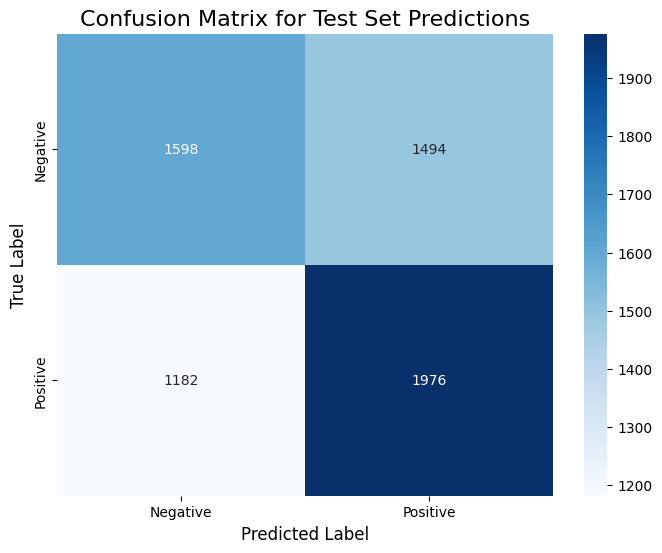

In [32]:
# --- Generate and Plot the Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)

# Use seaborn to create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix for Test Set Predictions', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.savefig('confusion_matrix.png')

print("\nConfusion matrix has been generated and saved as 'confusion_matrix.png'.")


In [34]:
# --- Generate the Classification Report ---
# This report includes precision, recall, and F1-score for each class.
report = classification_report(y_test, y_test_pred, target_names=['Negative', 'Positive'])

print("\n--- Classification Report for the Test Set ---")
print(report)


--- Classification Report for the Test Set ---
              precision    recall  f1-score   support

    Negative       0.57      0.52      0.54      3092
    Positive       0.57      0.63      0.60      3158

    accuracy                           0.57      6250
   macro avg       0.57      0.57      0.57      6250
weighted avg       0.57      0.57      0.57      6250




ROC curve with AUC = 0.6038 has been generated and saved as 'roc_curve.png'.


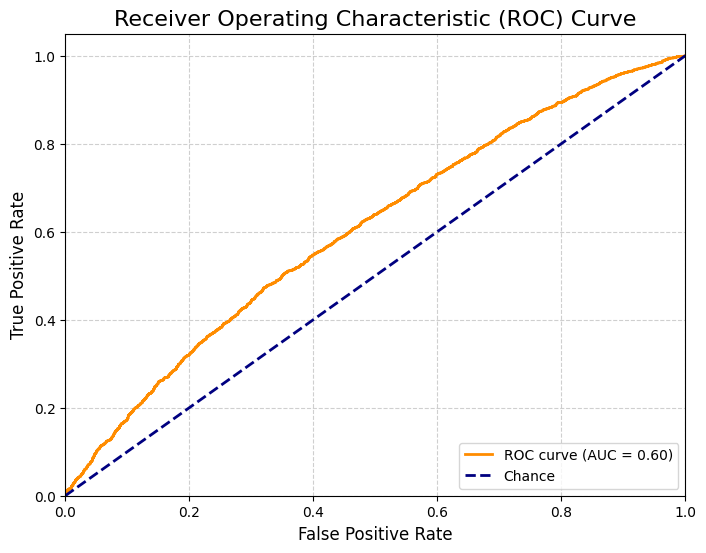

In [36]:
 # --- Generate ROC Curve Data ---
# Get the probability of the positive class (sentiment=1)
y_pred_proba = log_reg.predict_proba(X_test_tfidf)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# --- Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('roc_curve.png')

print(f"\nROC curve with AUC = {roc_auc:.4f} has been generated and saved as 'roc_curve.png'.")
